In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import copy
import itertools
import math
import random
import time

import gensim
import numpy as np
import scipy.spatial.distance as dist
from scipy.stats import bayes_mvs
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from joblib import Parallel, delayed

import sampl.gsn_api as gsn
import sampl.semantics as sem
import sampl.update as update
import sampl.paradigm_smith as ps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Context enhancement

In this notebook, we use our model to reproduce the context enhancement effect described in experiment 1 from Smith, Hasinski, & Sederberg (2013, henceforth SHS).

## Setting up the network

Stimuli in SHS were photographs of either indoor or outdoor scenes, but were essentially used as tokens. It was assumed that there was no preexisting relationship between the stimuli, and that the initial inter-item associations were formed during the study phase. We therefore initialized the network with an adjacency matrix consisting of all zeros.

## The experiment

A triplet consists of two context items followed by one target. Three types of triplets:

* Repeated context, repeated target. 1st: ABC. 2nd: ABC.
* Novel context, repeated target. 1st: ABC. 2nd: DEC.
* Repeated context, novel target. 1st: ABC. 2nd: ABD.
* Novel context, novel target. 1st: ABC. 2nd: DEF.

All triplets are presented twice with a random lag (6–21 items) between presentations.

360 stimuli in 5 study lists. Each study list contained 4 triplets of each type, for a total of 72 items (and 96 item presentations).

Item repetition effect is the contrast between hit rates for all twice-presented targets (novel contexts, repeated target and repeated context, repeated target) versus Once-presented targets (novel contexts, novel targets [NCNT] and repeated context, novel targets [RCNT]).

Context repetition effects are the contrasts between hit rates for once-presented targets preceded by a repeated context (RCNT) versus those preceded by a nonrepeated context (NCNT), calculated separately for the first and second targets associated to the repeated context and matched novel context. 

Target CRE1 = IRE * .73
Target CRE2 = 0

## Model parameter search

We used a simple grid search to find model parameters that reproduce the context enhancement effect from SHS.

In [3]:
y_max_grid = np.array([1.0, .8, .6, .5, .4, .3, .2, .1, 0])
y_min_grid = -1 * y_max_grid
dip_center_grid = [.1, .2, .3, .4, .5]
dip_width_grid = [.1, .2, .3, .4, .5]
discount_grid = [.1, .2, .3, .4, .5, .7, .9]

parameter_grid = list(itertools.product(
    y_min_grid, 
    y_max_grid, 
    dip_center_grid, 
    dip_width_grid, 
    discount_grid
))
len(parameter_grid)

14175

In [4]:
parameter_grid_shuffled = copy.deepcopy(parameter_grid)
random.shuffle(parameter_grid_shuffled)

In [5]:
my_grid = parameter_grid_shuffled

In [6]:
# N.B.: May take quite some time. Consider loading the cached results; see below.
# costs = ps.parameter_search(my_grid, n_sims=1)

In [7]:
# N.B.: Only do this is you ran the grid search and want to save the costs.
#np.save(file='costs_smith.npy', arr=costs)

In [8]:
# N.B.: Only do this is you want to load costs calculated using this notebook.
#costs = np.load(file='costs_smith.npy')

In [47]:
# N.B.: This is probably what you want to do.

# Load data from separately computed very large grid search
costs_mm = np.load(file='../grid_search_results/smith_results_mem_2019-04-08.npy')

The cost of each simulation at each point on the parameter grid was the ratio of the item repetition effect to the first-target context repetition effect, plus one if the confidence interval of the first-target context repetition effect overlapped with zero, and plus one if the confidence interval of the second-target context repetition effect did _not_ overlap with zero.

## Result: the model captures context enhancement

We visualize the result generated using the parameter set with the lowest cost. Note that the best model has a slight dip in its update function.

In [48]:
i_sort = np.argsort(costs_mm[:, 5])
i_win = i_sort[1]
costs_mm[i_win, :]

array([-0.5       ,  0.4       ,  0.2       ,  0.1       ,  0.3       ,
        0.28483838], dtype=float32)

In [49]:
op_win, study_list_win = ps.run_with_params(costs_mm[i_win, 0:5])
res_win = [ps.run_with_params(costs_mm[i_win, 0:5]) for _ in range(60)]
dfs_win = [ps.analyze_smith(r[0], r[1]) for r in res_win]
df_win = pd.concat(dfs_win)
cost_win = np.mean([ps.smith_cost(df) for df in dfs_win])
# N.B. This value might differ a bit from the grid search result due to noise
cost_win

0.3451425939666466

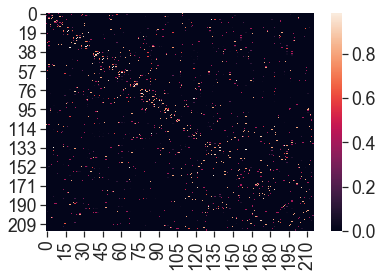

In [50]:
sns.heatmap(op_win.graph.adj)

In [51]:
def big_plot(df_win, op_win, sim_label="SAMPL", nmp_label="NMP"):
    sns.set(font_scale=1.6)
    sns.set_style('ticks')

    df_targets = [.082, .061, .003]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5), gridspec_kw={'width_ratios':[1, 1, 1.25]})
    sns.barplot(x='effect', y='contrast', data=df_win, ax=ax1, color=sns.color_palette()[0])
    ax1.set(xticklabels=['IRE', 'P-CRE', 'NP-CRE'])
    ax1.set_ylabel('Difference of in-degrees')
    ax1.set_xlabel('')
    ax1.set_title(sim_label)

    sns.barplot(x=[1,2,3], y=df_targets, ax=ax2, color=sns.color_palette()[1])
    ax2.set(xticklabels=['IRE', 'P-CRE', 'NP-CRE'])
    ax2.set_title("Human")
    ax2.set_ylabel('Difference of hit-rates')
    # Change y-limits so heights of IRE bars are matched
    ire_y = df_win[df_win['effect'] == 'Item repetition effect']['contrast'].mean()
    ylim_sim = ax1.get_ylim()
    ratio_sim_top = ylim_sim[1] / ire_y
    ratio_sim_bottom = -ylim_sim[0] / ylim_sim[1]
    shs_top = df_targets[0] * ratio_sim_top
    shs_bottom = -(shs_top * ratio_sim_bottom)
    ax2.set_ylim((shs_bottom, shs_top))

    xs = np.linspace(0, 1., 101)
    ys = op_win.update_fx(xs)
    ax3.plot(xs, ys)
    ax3.set_xlabel('Activation strength')
    ax3.set_ylabel('Weight change')
    ax3.set_title(nmp_label)
    ylim = ax3.get_ylim()
    one_percent_y = (ylim[1] - ylim[0]) / 100
    ax3.text(x=0, y=ylim[1] - one_percent_y * 5, s=f"Discount (γ) = {str(round(op_win.discount, 2))}")

    sns.despine()
    plt.tight_layout()

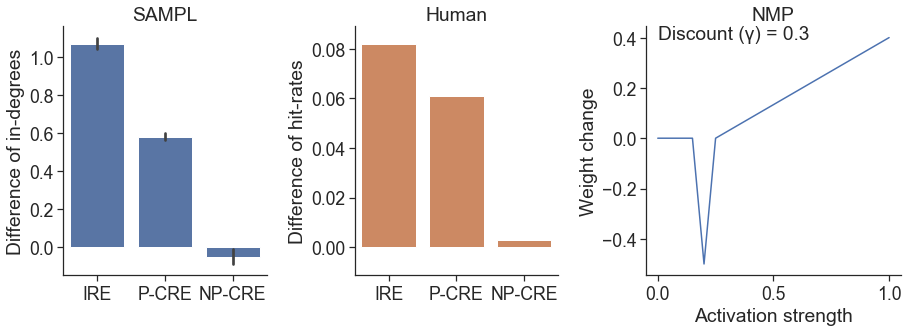

In [52]:
big_plot(df_win, op_win)

In [53]:
df_win.head()

,effect,contrast
0,Item repetition effect,1.376836
1,Item repetition effect,1.426879
2,Item repetition effect,0.724253
3,Item repetition effect,1.903970
4,Item repetition effect,1.878069


In [54]:
df_win['effect'].unique()

array(['Item repetition effect', 'Context repetition, 1st target',
       'Context repetition, 2nd target'], dtype=object)

In [55]:
ttest_ind(
    df_win[df_win['effect'] == 'Context repetition, 1st target']['contrast'].values, 
    df_win[df_win['effect'] == 'Item repetition effect']['contrast'].values,
    equal_var=False
)

Ttest_indResult(statistic=-27.75023920239981, pvalue=9.91527021915279e-145)

In [56]:
dof = (
    len(df_win[df_win['effect'] == 'Context repetition, 1st target']['contrast']) + 
    len(df_win[df_win['effect'] == 'Item repetition effect']['contrast']) - 2
)
dof

2158

In [57]:
(
    np.mean(df_win[df_win['effect'] == 'Context repetition, 1st target']['contrast'].values) -
    np.mean(df_win[df_win['effect'] == 'Item repetition effect']['contrast'].values)
)

-0.48810836711255756

In [58]:
(
    np.mean(df_win[df_win['effect'] == 'Context repetition, 1st target']['contrast'].values) /
    np.mean(df_win[df_win['effect'] == 'Item repetition effect']['contrast'].values)
)

0.5437547648596792

In [59]:
ttest_ind(
    df_win[df_win['effect'] == 'Context repetition, 1st target']['contrast'].values, 
    df_win[df_win['effect'] == 'Context repetition, 2nd target']['contrast'].values,
    equal_var=False
)

Ttest_indResult(statistic=29.274005310522355, pvalue=8.790868300531712e-137)

In [60]:
dof = (
    len(df_win[df_win['effect'] == 'Context repetition, 1st target']['contrast']) + 
    len(df_win[df_win['effect'] == 'Context repetition, 2nd target']['contrast']) - 2
)
dof

1438

In [61]:
(
    np.mean(df_win[df_win['effect'] == 'Context repetition, 1st target']['contrast'].values) -
    np.mean(df_win[df_win['effect'] == 'Context repetition, 2nd target']['contrast'].values)
)

0.6321671124481232

## Lesion analysis

In [62]:
params_lesion = copy.deepcopy(costs_mm[i_win, 0:5])
params_lesion[0] = 0
op_lesion, study_list_lesion = ps.run_with_params(params_lesion)
res_lesion = [ps.run_with_params(params_lesion) for _ in range(60)]
dfs_lesion = [ps.analyze_smith(r[0], r[1]) for r in res_lesion]
df_lesion = pd.concat(dfs_lesion)
cost_lesion = np.mean([ps.smith_cost(df) for df in dfs_lesion])
cost_lesion

1.0734137002148503

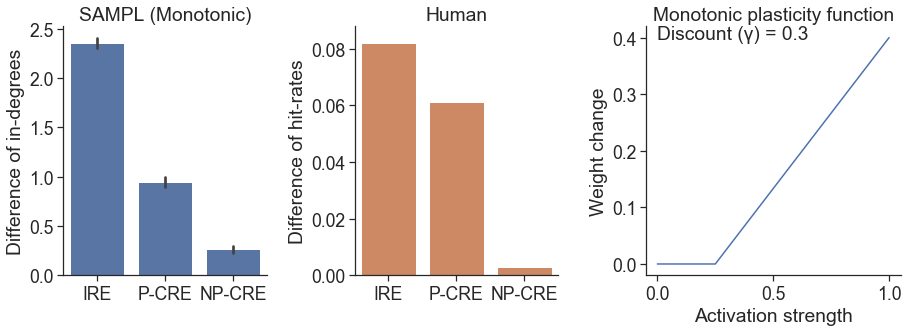

In [63]:
big_plot(df_lesion, op_lesion, sim_label="SAMPL (Monotonic)", nmp_label="Monotonic plasticity function")

## Result 2: inhibition plays a role in context enhancement

We visualize how the cost changes as a function of the suppression, enhancement, and discount (gamma) model parameters, as the other model parameters are held constant. Lower cost indicates a better fit of the behavior of the model to the results from SHS.

The model performs best when enhancement is high, and when there is very small but non-zero suppression. The suppression parameter has a strong influence on the context repetition effects for both the first and second targets (CRE1 and CRE2), visualized below. If there is too much suppression (e.g., values ≤ -.05), context enhancement effects do not emerge. Critically, however, when there is too little suppression (e.g., values ≥ -.01), there is a strong context repetition effect for item 2 not seen in the results from SHS.

In [64]:
i_win

5462

In [65]:
costs_mm[i_win]

array([-0.5       ,  0.4       ,  0.2       ,  0.1       ,  0.3       ,
        0.28483838], dtype=float32)

In [68]:
y_min, y_max, dip_center, dip_width, discount = costs_mm[i_win, 0:5].astype(np.float64).round(2)
n_sims = 30

y_min_param_sets = []
y_min_unique = list(np.round(np.linspace(-1, 0, 21), 2))
for v in y_min_unique:
    y_min_param_sets.append(
        (v, y_max, dip_center, dip_width, discount)
    )
y_min_results = [[ps.run_with_params(p) for _ in range(n_sims)] for p in y_min_param_sets]
y_min_dfs = [[ps.analyze_smith(r[0], r[1]) for r in rs] for rs in y_min_results]
y_min_costs = np.array([np.mean([ps.smith_cost(df) for df in dfs]) for dfs in y_min_dfs])

y_max_param_sets = []
y_max_unique = list(np.round(np.linspace(0, 1, 21), 2))
for v in y_max_unique:
    y_max_param_sets.append(
        (y_min, v, dip_center, dip_width, discount)
    )
y_max_results = [[ps.run_with_params(p) for _ in range(n_sims)] for p in y_max_param_sets]
y_max_dfs = [[ps.analyze_smith(r[0], r[1]) for r in rs] for rs in y_max_results]
y_max_costs = np.array([np.mean([ps.smith_cost(df) for df in dfs]) for dfs in y_max_dfs])

discount_param_sets = []
discount_unique = list(np.round(np.linspace(0, 1, 21), 2))
for v in discount_unique:
    discount_param_sets.append(
        (y_min, y_max, dip_center, dip_width, v)
    )
discount_results = [[ps.run_with_params(p) for _ in range(n_sims)] for p in discount_param_sets]
discount_dfs = [[ps.analyze_smith(r[0], r[1]) for r in rs] for rs in discount_results]
discount_costs = np.array([np.mean([ps.smith_cost(df) for df in dfs]) for dfs in discount_dfs])

# Remove duplicate x and y values that result from overlap between the
# grid search and the block above. This is because the results might differ
# between the grid search and the block because of noise. For clarity we only
# want to report the grid search value

y_min_costs[y_min_unique == y_min] = costs_mm[i_win, -1]
y_max_costs[y_max_unique == y_max] = costs_mm[i_win, -1]
discount_costs[discount_unique == discount] = costs_mm[i_win, -1]

/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/beau/miniconda3/envs/latest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
msize=5
ax1.plot(y_min_unique, y_min_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax1.plot(y_min, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax1.set_xlabel('Suppression (y-min)')
ax1.set_ylabel('Cost')
ax1.set_xlim((y_min_unique[0], y_min_unique[-1] + .1))

ax2.plot(y_max_unique, y_max_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax2.plot(y_max, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax2.set_xlabel('Enhancement (y-max)')
ax2.set_ylabel('Cost')
ax2.set_xlim((y_max_unique[0], y_max_unique[-1] + .1))

ax3.plot(discount_unique, discount_costs, 'o-', markersize=msize, color=sns.color_palette()[0])
ax3.plot(discount, cost_win, 'o', markersize=msize+.5, color=sns.color_palette()[3])
ax3.set_xlabel('Discount (γ)')
ax3.set_ylabel('Cost')
ax3.set_xlim((discount_unique[0], discount_unique[-1] + .1))

plt.tight_layout()
sns.despine()

In [ ]:
y_min_costs

In [ ]:
df_list = []
for i, y_min in enumerate(y_min_unique):
    df = pd.concat(y_min_dfs[i])
    df['y'] = y_min
    df_list.append(df)
df_cat = pd.concat(df_list)
df_cat.head()

In [ ]:
df_cat['effect'].unique()

In [ ]:
df_cat[df_cat['effect'] == 'Context repetition, 2nd target'].head()

In [ ]:
pearsonr(
    df_cat[df_cat['effect'] == 'Context repetition, 1st target']['contrast'],
    df_cat[df_cat['effect'] == 'Context repetition, 1st target']['y']
)

In [ ]:
pearsonr(
    df_cat[df_cat['effect'] == 'Context repetition, 2nd target']['y'],
    df_cat[df_cat['effect'] == 'Context repetition, 2nd target']['contrast']
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

sns.lineplot(
    data=df_cat[df_cat['effect'] == 'Context repetition, 1st target'], 
    x='y', 
    y='contrast',
    color=sns.color_palette()[0],
    ax=ax1
)
ax1.set_xlabel('Suppression (y-min)')
ax1.set_ylabel('Predictive CRE')
#for label in ax1.xaxis.get_ticklabels()[1::2]:
#    label.set_visible(False)
#ax1.axhline(df_targets[1], color=sns.color_palette()[1])
ax1.axhline(0, color='gray', alpha=0.75, linewidth=0.5)
ax1_max = ax1.get_ylim()[1]

sns.lineplot(
    data=df_cat[df_cat['effect'] == 'Context repetition, 2nd target'], 
    x='y', 
    y='contrast',
    color=sns.color_palette()[0],
    ax=ax2
)
ax2.set_xlabel('Suppression (y-min)')
ax2.set_ylabel('Non-predictive CRE')
#for label in ax2.xaxis.get_ticklabels()[1::2]:
#    label.set_visible(False)
#ax2.axhline(df_targets[2], color=sns.color_palette()[1])
ax2.axhline(0, color='gray', alpha=0.75, linewidth=0.5)
ax2_min = ax2.get_ylim()[0]

ax1.set_ylim((ax2_min, ax1_max))
ax2.set_ylim((ax2_min, ax1_max))

plt.tight_layout()
sns.despine()